In [129]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import contextily as ctx


In [228]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

dbi = gpd.read_feather('../data/dbi_permits.geofeather')

fees = gpd.read_file('../data/Neighborhood-Specific Impact Fee Areas.geojson')

dbi = dbi.sort_values('permit_creation_date', ascending=False)

dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
df = pd.merge(dbi[['geometry', 'permit_number']], homes, left_on='permit_number', right_on='BPA', how='inner')

df = df[df['Permit Issued Date'].dt.year > 2010]

In [229]:
df.shape

(3605, 71)

In [231]:
fees.loc[fees.tier.str.contains('Tier 1 if residential') == True, 'tier'] = 'Tier 1'

#### Tier 1 vs Tier 2

In [232]:
simplefees = fees[fees.tier.isin(['Tier 1', 'Tier 2'])] # , 'Tier 3'

In [233]:
simplefees

,area,tier,url,objectid,ordinance,fee,geometry
5,NaN,Tier 1,https://codelibrary.amlegal.com/codes/san_fran...,11,Planning Code Section 423,Eastern Neighborhoods Infrastructure Impact Fe...,"MULTIPOLYGON (((-122.41727 37.74832, -122.4173..."
15,NaN,Tier 1,https://codelibrary.amlegal.com/codes/san_fran...,32,Planning Code Section 423,Eastern Neighborhoods Infrastructure Impact Fe...,"MULTIPOLYGON (((-122.40321 37.77182, -122.4045..."
19,NaN,Tier 1,https://codelibrary.amlegal.com/codes/san_fran...,42,Planning Code Section 423,Eastern Neighborhoods Infrastructure Impact Fe...,"MULTIPOLYGON (((-122.40884 37.76723, -122.4085..."
31,NaN,Tier 2,https://codelibrary.amlegal.com/codes/san_fran...,10,Planning Code Section 423,Eastern Neighborhoods Infrastructure Impact Fe...,"MULTIPOLYGON (((-122.41737 37.74831, -122.4178..."


In [88]:
east_homes = gpd.sjoin(df, simplefees[['tier', 'geometry']], how='inner', predicate='within')

In [131]:
simplefees.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

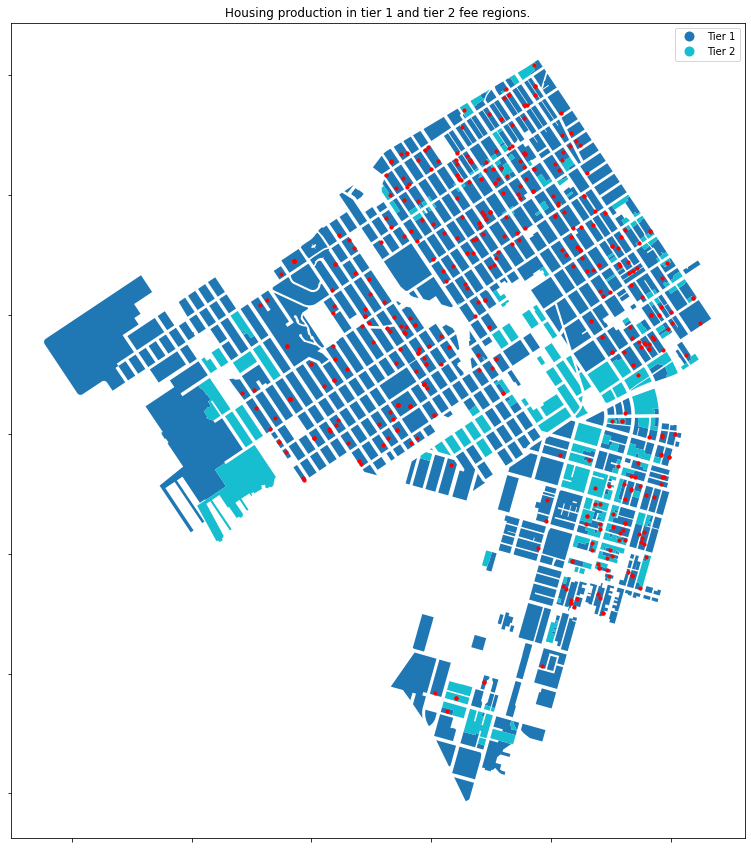

In [143]:
fig, ax = plt.subplots(figsize=(15, 15))
simplefees.plot(ax=ax, column='tier', legend=True)
ax.set_yticklabels([])
ax.set_xticklabels([])
east_homes.plot(ax=ax, c='red', markersize=10)
plt.title('Housing production in tier 1 and tier 2 fee regions.')
plt.savefig(f'rdd1.png', dpi=500)

In [160]:
west_most_point = east_homes[east_homes['geometry'].x == east_homes['geometry'].x.max()]

In [164]:
west_most_point.geometry.distance(simplefees.geometry.iat[1])

1886    187.689346
dtype: float64

In [163]:
simplefees

,area,tier,url,objectid,ordinance,fee,geometry
5,NaN,Tier 1,https://codelibrary.amlegal.com/codes/san_fran...,11,Planning Code Section 423,Eastern Neighborhoods Infrastructure Impact Fe...,"MULTIPOLYGON (((-3312560.150 14848853.171, -33..."
31,NaN,Tier 2,https://codelibrary.amlegal.com/codes/san_fran...,10,Planning Code Section 423,Eastern Neighborhoods Infrastructure Impact Fe...,"MULTIPOLYGON (((-3312551.557 14848858.305, -33..."


In [144]:
east_homes = east_homes.to_crs(32633)

simplefees = simplefees.to_crs(32633)

east_homes['dist_to_tier1'] = east_homes.geometry.distance(simplefees.geometry.iat[0])
east_homes['dist_to_tier2'] = east_homes.geometry.distance(simplefees.geometry.iat[1])

((east_homes['dist_to_tier1'] == 0) ^ (east_homes['dist_to_tier2'] == 0)).all()

True

In [150]:
east_homes.geometry.distance(simplefees.geometry.iat[0])

3         0.000000
5         0.000000
14        0.000000
21        0.000000
23        0.000000
           ...    
3050     18.003866
3122     20.054802
3270    106.457544
3271    106.457544
3365      4.538884
Length: 424, dtype: float64

In [237]:
east_homes['dist_to_boundary'] = np.maximum(east_homes['dist_to_tier1'], east_homes['dist_to_tier2'])

east_homes['dist_to_boundary'] = east_homes['dist_to_boundary'] * ((-1)**(east_homes['tier'] == 'Tier 2'))

boundary_homes = east_homes[(np.absolute(east_homes['dist_to_boundary']) < 200)]

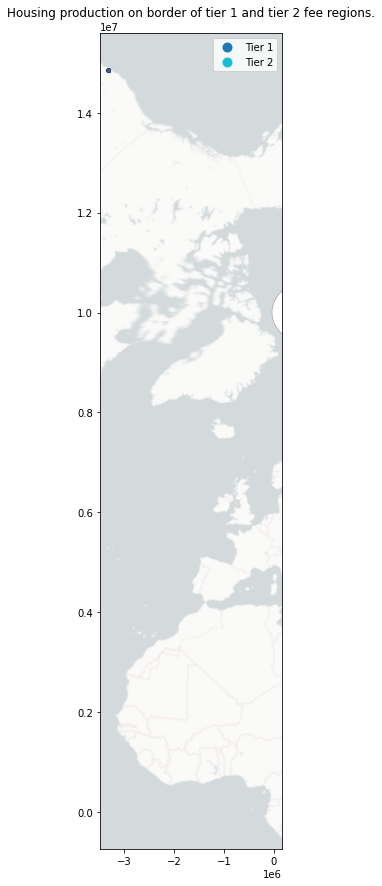

In [238]:
fig, ax = plt.subplots(figsize=(15, 15))
simplefees.plot(ax=ax, column='tier', legend=True)
boundary_homes.plot(ax=ax, c='red', column='dist_to_boundary', markersize=10)
plt.title('Housing production on border of tier 1 and tier 2 fee regions.')
plt.savefig(f'rdd2.png', dpi=500)
ctx.add_basemap(ax, crs=boundary_homes.crs, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)


(array([ 2.,  1.,  0.,  4.,  1., 11., 12., 27., 18., 22., 23., 20., 34.,
        24., 13., 10., 13., 16.,  6.,  7.]),
 array([-106.45754351,  -91.1723357 ,  -75.88712788,  -60.60192007,
         -45.31671226,  -30.03150445,  -14.74629664,    0.53891117,
          15.82411899,   31.1093268 ,   46.39453461,   61.67974242,
          76.96495023,   92.25015805,  107.53536586,  122.82057367,
         138.10578148,  153.39098929,  168.6761971 ,  183.96140492,
         199.24661273]),
 <BarContainer object of 20 artists>)

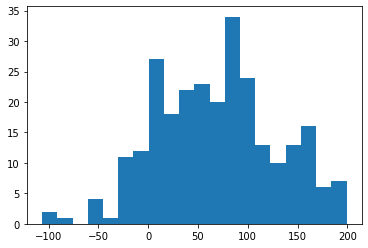

In [169]:
plt.hist(boundary_homes['dist_to_boundary'], bins=20)

In [94]:
{'Tier 1': 8,
 'Tier 2': 12,
 'Tier 3': 16}

{'Tier 1': 8, 'Tier 2': 12, 'Tier 3': 16}

In [170]:
parcels = gpd.read_feather('../data/df4.geofeather')

In [171]:
simplefees = simplefees.to_crs(parcels.crs)

In [172]:
east_parcels = gpd.sjoin(parcels, simplefees[['tier', 'geometry']], how='inner', predicate='intersects')

In [173]:
east_parcels = east_parcels.to_crs(32633)

simplefees = simplefees.to_crs(32633)

east_parcels['dist_to_tier1'] = east_parcels.geometry.distance(simplefees.geometry.iat[0])
east_parcels['dist_to_tier2'] = east_parcels.geometry.distance(simplefees.geometry.iat[1])

((east_parcels['dist_to_tier1'] == 0) ^ (east_parcels['dist_to_tier2'] == 0)).all()

False

In [174]:
east_parcels['dist_to_boundary'] = np.maximum(east_parcels['dist_to_tier1'], east_parcels['dist_to_tier2'])

east_parcels['dist_to_boundary'] = east_parcels['dist_to_boundary'] * ((-1)**(east_parcels['tier'] == 'Tier 2'))



<Axes: >

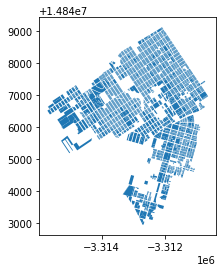

In [175]:
east_parcels.plot()

In [176]:
df = df.to_crs(east_parcels.crs)

In [177]:
east_parcels = east_parcels.drop(['index_right', 'index'], axis=1)

In [178]:
built_parcels = gpd.sjoin(east_parcels, df, how='left', predicate='contains')

In [179]:
built_parcels['Date_Completed'].isna().sum()

9867

In [180]:
built_parcels['built'] = built_parcels['Date_Completed'].notna()

<Axes: >

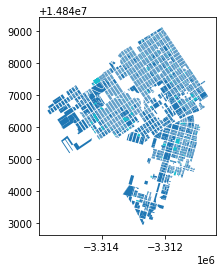

In [181]:
built_parcels.plot(column='built')

In [208]:
boundary_parcels = built_parcels[(np.absolute(built_parcels['dist_to_boundary']) < 150)]

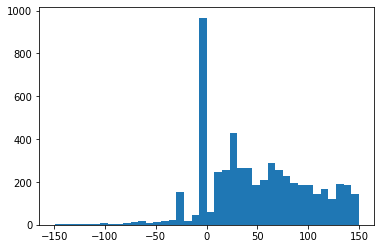

In [209]:
plt.hist(boundary_parcels['dist_to_boundary'], bins=40)
plt.show()

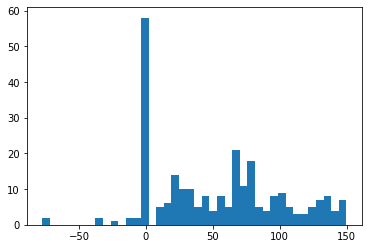

In [210]:
plt.hist(boundary_parcels[boundary_parcels['built']]['dist_to_boundary'], bins=40)
plt.show()

In [236]:
boundary_parcels.shape

(5530, 179)

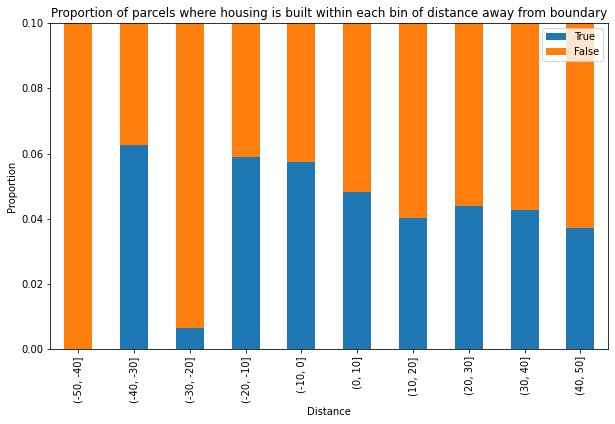

In [217]:
df = boundary_parcels.copy()
df['distance_bin'] = pd.cut(df['dist_to_boundary'], bins=np.arange(-50, 51, 10))

# Now calculate the proportions
df_built_true = df[df['built']].groupby('distance_bin').size() / df.groupby('distance_bin').size()
df_built_false = 1 - df_built_true

# Combine the true and false proportions into a single DataFrame
df_built = pd.DataFrame({'True': df_built_true, 'False': df_built_false}).reset_index()

# Plot
df_built.plot(x='distance_bin', y=['True', 'False'], kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Distance')
plt.ylabel('Proportion')
plt.ylim((0, .1))
plt.title('Proportion of parcels where housing is built within each bin of distance away from boundary')
plt.xticks(rotation=90)  # To make x-axis labels more readable
plt.savefig(f'rdd3.png', dpi=500)

In [218]:
df.groupby('distance_bin').size()

distance_bin
(-50, -40]     17
(-40, -30]     32
(-30, -20]    156
(-20, -10]     34
(-10, 0]      452
(0, 10]       707
(10, 20]      274
(20, 30]      545
(30, 40]      327
(40, 50]      323
dtype: int64

In [200]:
(boundary_parcels['dist_to_boundary'] == 0).sum()

8

In [201]:
boundary_parcels = boundary_parcels[boundary_parcels['dist_to_boundary'] != 0]

In [202]:
(boundary_parcels['built'] & (boundary_parcels['dist_to_boundary'] == 0)).sum()

0

In [203]:
boundary_parcels = boundary_parcels.copy()

In [204]:
boundary_parcels.to_csv('../clean_tier1_2_boundaries.csv')